https://blog.naver.com/jewdsa813/222200570774

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

# 다변수 칼만 필터
- 여러가지 확률변수 필터링하기

In [ ]:
%matplotlib inline
import book_format
book_format.set_style()

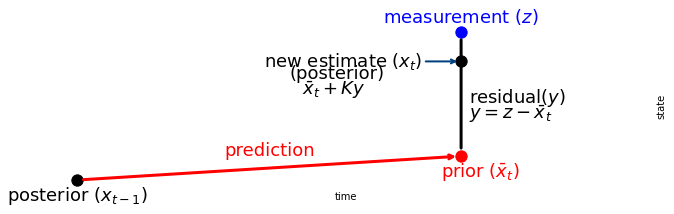

In [2]:
# 알고리즘 그래픽
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

## 1차원에서 개 추적하기, 가우스 함수를 곱하고 추가하기..

* 개 시뮬레이션 작성
* 시뮬레이션은 각 카운트 단계에 대해 실행
* 각 단계마다 개를 1미터 앞으로 이동
* 각 단계에서 속도는 프로세스 분산(process_var)에 따라 달라짐
* 위치를 업데이트 한 뒤 센서 분산(z_var)으로 측정 계산
* 이 함수는 측정값과 위치의 NumPy array 반환

### 예측 단계(predict step)
* 상태 및 공분산(x, P), 프로세스 모델 및 프로세스 노이즈(F, Q), 선택사항 으로 제어 입력 설계


- 평균은 가장 가능성이 높은 위치, 분산은 위치의 확률분포, 위치는 시스템의 상태, 이때 평균을 상태변수라고 함
- 상태변수는 센서로 직접 측정되는 관측변수거나, 관찰된 변수에서 유추한 숨겨진 변수일 수 있음
- 위치와 속도를 모두 추적하기 위해서 상태벡터 x, 공분산행렬 P로 표현된 가우스 함수 사용
- 개 추적 문제의 경우 센서가 위치만 판독하므로 위치가 관찰되고 속도가 숨겨짐, 숨겨진 변수를 추적


In [3]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1):
  "return track, measurement 1D ndarrays"
  x, vel = 1., 1. # 위치, 속도
  z_std = math.sqrt(z_var)
  p_std = math.sqrt(process_var)
  xs, zs = [], [] # 예측치, 측정값?
  for _ in range(count):
    v = vel + (randn() * p_std)
    x += v * dt
    xs.append(x)
    zs.append(x + randn() * z_std)
  return np.array(xs), np.array(zs)

* 상태 변수 설계

In [5]:
# 상태변수, x를 초기화
x = np.array([[10.0], [4.5]])
x

array([[10. ],
       [ 4.5]])

In [6]:
# 행벡터 -> 열백터, 전치 사용
x = np.array([[10.0, 4.5]]).T
x

array([[10. ],
       [ 4.5]])

In [7]:
# numpy는 1D array를 벡터로 인식함, 1D array로 표기
x = np.array([10.0, 4.5])
x


array([10. ,  4.5])

In [8]:
# 형태 한가지로 통일 float 한개만 있어도 전체 다 float 처리 됨
np.array([1., 0, 0, 0, 0])

array([1., 0., 0., 0., 0.])

In [10]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.], [4.5]])
print(np.dot(A, x))
print(A @ x)


[[19.]
 [48.]]
[[19.]
 [48.]]


In [11]:
x = np.array([[10., 4.5]]).T
print(A @ x)

x = np.array([10.0, 4.5])
print(A @ x) # 1D array 형식으로 반환되지만 칼만필터는 이 구조체를 벡터로 잘 인식됨

[[19.]
 [48.]]
[19. 48.]


* 상태 공분산 설계
> 공분산행렬 P
> * 1차원 칼만필터: 분산에 대한 초깃값을 지정한 후 필터에 측정값을 추가하여 추정값 업데이트
> * 다차원 칼만필터: 공분산 P에 대한 초깃값 지정한 후 필터는 각 기간이 지날때마다 업데이트
> - 공분산 행렬의 대각선에는 각 변수의 분산이 포함, 비대각 원소는 공분산 포함

In [13]:
# numpy.diag, 비대각 원소에 0이 있는 행렬
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

In [15]:
P = np.array([[500., 0.], [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

* 프로세스 모델 설계

> 시스템 동작 설명하는 수학적 모델

> 필터는 프로세스 모델을 사용해 이산시간 단계 이후 상태 예측

> 시스템의 역학을 설명하는 일련의 방정식을 가지고 프로세스 모델 설계

In [ ]:
def predect(pos, movement):
  return gaussian(pos.mean + movement.mean, pos.var + movement.var)